In [374]:
%config Completer.use_jedi = True
# %matplotlib widget



In [375]:
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pandas as pd
import seaborn as sns
import scipy
from scipy import stats
from sklearn import metrics
import pybedtools
import coolbox
from coolbox.api import *
import networkx as nx
from joblib.externals.loky import set_loky_pickler
from joblib import parallel_backend
from joblib import Parallel, delayed
from joblib import wrap_non_picklable_objects
os.chdir('/home/dcmorgan')
os.getcwd()

'/home/dcmorgan'

In [ ]:
!cut -f2,3,4 ~/data/meta/NC_004252_R0396-MWT.bedgraph

## Raw Gut x pheno

In [ ]:
primary=pd.read_excel('data/Data Raw - Gut Microbiome Cohort Project Database - 300 Cohort v3.0_280921.xlsx',index_col=0,sheet_name='Primary Data')
diet=pd.read_excel('data/Data Raw - Gut Microbiome Cohort Project Database - 300 Cohort v3.0_280921.xlsx',index_col=0,sheet_name='Diet Data')
blood_stool=pd.read_excel('data/Data Raw - Gut Microbiome Cohort Project Database - 300 Cohort v3.0_280921.xlsx',index_col=0,sheet_name='blood and stool biomarkers')
secondary=pd.read_excel('data/Data Raw - Gut Microbiome Cohort Project Database - 300 Cohort v3.0_280921.xlsx',index_col=0,sheet_name='Secondary Data')
MRI=pd.read_excel('data/Data Raw - Gut Microbiome Cohort Project Database - 300 Cohort v3.0_280921.xlsx',index_col=0,sheet_name='MRI scores')

In [ ]:
unibact=pd.read_csv('data/328_krakenuniq_raw.csv',index_col=0)
unibact['spec']=(unibact.index).str.split(';').str[0:6].tolist()
# jeff=pd.DataFrame(unibact['spec'].tolist(),columns=['tmp','tmp','tmp','tmp','tmp','species'])
# jeff=jeff.fillna(method='ffill',axis=1)


In [ ]:
unibact.columns=unibact.columns.str.split('-').str[0].tolist()

In [ ]:
PP=primary[primary.index.isin(unibact.columns)]



In [ ]:
sub_uni=unibact[primary.index[primary.index.isin(unibact.columns)]]
sub_uni.columns=PP['Hypertension Category by 24h BP w/o considering antihypertensive med']
# sub_uni

### corr network

In [ ]:
aa=np.corrcoef((sub_uni[2]).astype(float))
# aa=aa[aa!=1]
a=plt.hist(aa.flatten(),bins=100,log=True,alpha=.65)

bb=np.corrcoef((sub_uni[1]).astype(float))
# bb=bb[bb!=1]
b=plt.hist(bb.flatten(),bins=100,log=True,alpha=.5)

cc=np.corrcoef((sub_uni[0]).astype(float))
# cc=cc[cc!=1]
c=plt.hist(cc.flatten(),bins=100,log=True,alpha=.35)

In [ ]:
a=nx.from_numpy_array(aa[1:100,1:100])
b=nx.from_numpy_array(bb[1:100,1:100])
c=nx.from_numpy_array(cc[1:100,1:100])

# cc.shape

In [ ]:
nx.draw(a)
nx.draw(b)
nx.draw(c)

In [ ]:
# nx.from_numpy_array(aa[(aa>.5)&(aa[1:100,1:100])])
nx.average_clustering(a)

In [ ]:
aa=np.array(stats.spearmanr(sub_uni[2],axis=1))
# aa=aa[aa!=1]
a=plt.hist(aa.flatten(),bins=100,log=True,alpha=.65)

bb=np.array(stats.spearmanr(sub_uni[1],axis=1))
# bb=bb[bb!=1]
b=plt.hist(bb.flatten(),bins=100,log=True,alpha=.5)

cc=np.array(stats.spearmanr(sub_uni[0],axis=1))
# cc=cc[cc!=1]
c=plt.hist(cc.flatten(),bins=100,log=True,alpha=.35)

In [ ]:
ww=plt.hist(bb-cc,bins=100,alpha=.65,log=True)
ww=plt.hist(bb-aa,bins=100,alpha=.5,log=True)
ww=plt.hist(aa-cc,bins=100,alpha=.35,log=True)

In [ ]:
from scipy import stats
cc=np.array(stats.spearmanr(unibact.values[0:1000,0:1000])).flatten()
cc=cc[cc!=1]
# np.array(cc)
cc=plt.hist(cc,bins=100,log=True)

## OriC data

In [183]:
oric=pd.read_csv('data/doric10/tubic_bacteria.csv') #remove 'note' and 'nt*' from file

In [184]:
oric['oric_start']=oric['Location of replication origin'].str.split('.').str[0].str.split(',').str[0].str.split(';').str[0].tolist()
oric['oric_end']=oric['Location of replication origin'].str.split('.').str[2].str.split(',').str[0].str.split(';').str[0].tolist()
oric['gene_start']=oric['Location of replication genes'].str.split('.').str[0].str.split(',').str[0].str.split(';').str[0].tolist()
oric['gene_end']=oric['Location of replication genes'].str.split('.').str[2].str.split(',').str[0].str.split(';').str[0].tolist()

In [185]:
oric['OriC AT content']=np.round(oric['OriC AT content']*100).astype(int)
oric['orgA']=oric['Organism'].str.split(' ').str[0].tolist()
oric['orgB']=oric['Organism'].str.split(' ').str[1].tolist()
oric['Organism']=oric['orgA']+'_'+oric['orgB']


In [186]:
oric[['oric_start','oric_end','gene_start','gene_end']]=oric[['oric_start','oric_end','gene_start','gene_end']].replace('-','1')
oric=oric.fillna('1')

In [210]:
oric[['gene_start']]=oric[['gene_start']].astype(int)
oric[['gene_end']]=oric[['gene_end']].astype(int)
oric[['oric_start']]=oric[['oric_start']].astype(int)
oric[['oric_end']]=oric[['oric_end']].astype(int)

In [211]:
# oric['end']=np.amax(oric[['oric_start','oric_end','gene_start','gene_end']],1)
# oric['start']=np.amin(oric[['oric_start','oric_end','gene_start','gene_end']],1)
jj=ori[ori['oric_start']>ori['oric_end']]#
jj['oric_end']=jj['oric_start']+jj['oric_end']
ff=ori[ori['oric_start']<ori['oric_end']]
ORIC=ff.append(jj)

In [253]:
ORIC['refseq']=ORIC['Refseq'].str.split('.').str[0].tolist()
ORIC['len']=ORIC['oric_end']-ORIC['oric_start']

In [254]:
ORIC[['refseq','oric_start','oric_end','OriC AT content','Organism','len']].to_csv('data/doric10/OriC_db.bed',sep='\t',header=True,index=False)

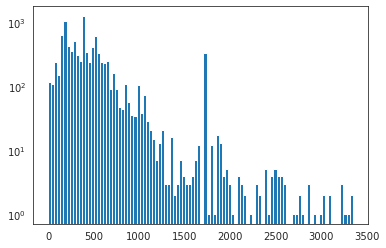

In [255]:
sns.set_style("white")
tmp=plt.hist(ORIC['len'],bins=100,log=True)

## circular plots

In [ ]:
zzz=pd.read_csv(jac,sep='\t',names=['tmp','start','end','relAb'])
tmp=ori[ori['Refseq'].str.contains('NC_'+jac.split('/')[2].split('_')[1])]
plt.figure(figsize=(20, 5))

plt.bar(data=zzz[(zzz['start']>3000000)&(zzz['end']<3500000)],x='start',height='relAb',label='align',color='blue')#][zzz['start']=='1665929']
plt.bar(data=tmp,x='start',height='OriC AT content',label='OriC start',color='orange')
plt.bar(data=tmp,x='end',height='OriC AT content',label='OriC end',color='orange')

plt.axes([.2, .6, .6, .2])
plt.bar(data=zzz[(zzz['start']>np.int(np.round(tmp['start'].item(),-1))-100) &(zzz['end']<np.int(np.round(tmp['end'].item(),-1))+100)],x='start',height='relAb',label='align',color='blue')#][zzz['start']=='1665929']
plt.bar(data=tmp,x='start',height='OriC AT content',label='OriC start',color='orange')
plt.bar(data=tmp,x='end',height='OriC AT content',label='OriC end',color='orange')


plt.xlabel("OriC ranges from "+str(tmp['start'].item())+" to "+str(tmp['end'].item())+" for "
        +str(tmp['Organism'].item())+" in "+str(os.path.basename(jac).split('_')[2].split('.')[0])+
           "max= "+np.max(zzz['relAb'])+" at "+str(zzz[zzz['relAb']==np.max(zzz['relAb'])][['start']].index.values)+"; median= "+np.median(zzz['relAb']),fontsize=14)
 

In [568]:
# traces[1]
tmp

,Refseq,start,end,OriC AT content,Organism
1064,NC_012781.1,1,3449685,73,Eubacterium_rectale


In [10]:
traces= glob.glob('data/meta_unfilt/*bedgraph')
ori=pd.read_csv('data/doric10/OriC_db.bed',sep='\t')

# for jac in traces:
jac=traces[1]
zzz=pd.read_csv(jac,sep='\t',names=['tmp','start','end','relAb'])
tmp=ori[ori['Refseq'].str.contains('NC_'+jac.split('/')[2].split('_')[1])]

aa=zzz[['start','relAb']]
aa.rename(columns={"start":"Name","relAb":"Value"},inplace=True)
df0=aa.groupby(aa.index // 2000).sum()
df=(df0)
df=df0
df['Name']=np.round(df['Name'],3)
df=df.sort_values(by=['Name'])
# df=df0
# del df['Value']
# df=df.rename(columns={'logValue':"Value"})

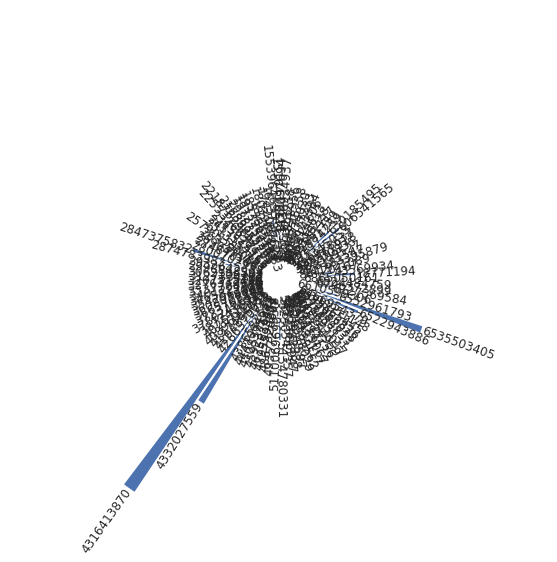

In [566]:
# set figure size
plt.figure(figsize=(20,10))

# plot polar axis
ax = plt.subplot(111, polar=True)

# remove grid
plt.axis('off')

# Set the coordinates limits
upperLimit = 100#np.max(df.Value)
lowerLimit = 10#np.min(df.Value)

# Compute max and min in the dataset
max = df['Value'].max()

# Let's compute heights: they are a conversion of each item value in those new coordinates
# In our example, 0 in the dataset will be converted to the lowerLimit (10)
# The maximum will be converted to the upperLimit (100)
slope = (max - lowerLimit) / max
heights = slope * df.Value + lowerLimit

# Compute the width of each bar. In total we have 2*Pi = 360°
width = 2*np.pi / len(df.index)

# Compute the angle each bar is centered on:
indexes = list(range(1, len(df.index)+1))
angles = [element * width for element in indexes]
angles

# Draw bars
bars = ax.bar(
    x=angles, 
    height=heights, 
    width=width, 
    bottom=lowerLimit,
    linewidth=2, 
    edgecolor="white")


# little space between the bar and the label
labelPadding = 4

# Add labels
for bar, angle, height, label in zip(bars,angles, heights, df["Name"]):

    # Labels are rotated. Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle)

    # Flip some labels upside down
    alignment = ""
    if angle >= np.pi/2 and angle < 3*np.pi/2:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"

    # Finally add the labels
    ax.text(
        x=angle, 
        y=lowerLimit + bar.get_height() + labelPadding, 
        s=label, 
        ha=alignment, 
        va='center', 
        rotation=rotation, 
        rotation_mode="anchor") 

## circular plot 2

[adapted from tutorial](https://www.python-graph-gallery.com/web-circular-lollipop-plot-with-matplotlib)

[checkout GCskew wiki](https://en.wikipedia.org/wiki/GC_skew)

In [354]:
jeff3

,index,relAb
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
2878892,7836,0
2878893,7836,0
2878894,7836,0
2878895,7836,0


In [362]:
# qq=np.max(jeff3.groupby(jeff3.index // 10000).sum()['relAb'])
np.round(qq,-4)

1050000

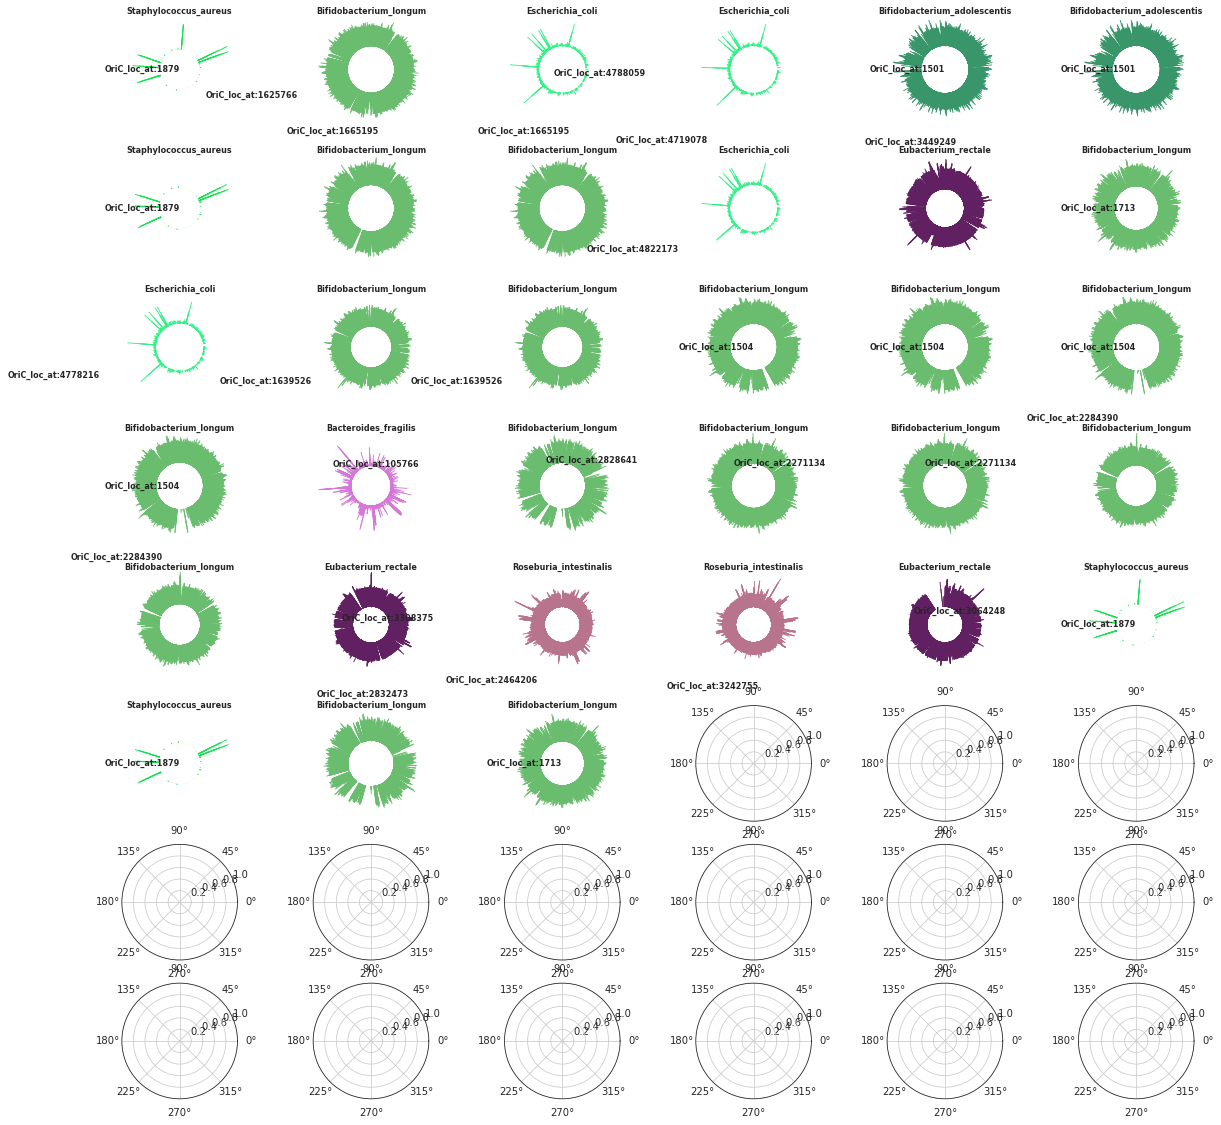

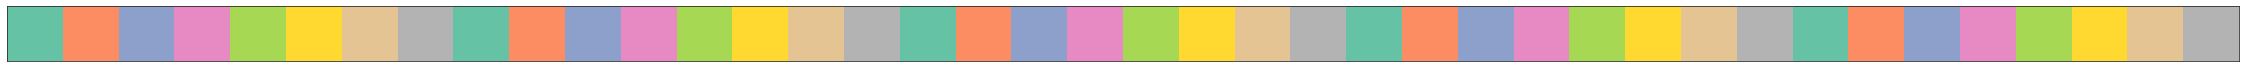

In [373]:
import random
# The plot consists of 2 rows and 5 columns (10 categories in total)
fig, axes = plt.subplots(8, 6, figsize=(20, 20), subplot_kw={"projection": "polar"})
fig.patch.set_facecolor("white")
PLUS = 10
table=[]

traces= np.sort(glob.glob('data/meta*/*bedgraph'))
ori=pd.read_csv('data/doric10/OriC_db.bed',sep='\t')
# cc=ori[ori['Organism']!=('Bifidobacterium_longum')]
cc=ori
dd=cc[cc['refseq'].str.contains('NC_')]['refseq']


ori=pd.read_csv('data/doric10/OriC_db.bed',sep='\t')
SLICES = [(i, j) for i in range(8) for j in range(6)]
i=0
sns.palplot(sns.color_palette("Set2", 40))
color=pd.DataFrame()
color0=pd.DataFrame(columns=['color','species'])
# for jac in traces[0::151]:

for d in dd:
    indices = [i for i, s in enumerate(traces) if d in s]
    # if not indices.empty:
    if indices !=[]:
        jac=traces[indices[0]]
        ax = axes[SLICES[i]]
        zzz=pd.read_csv(jac,sep='\t',names=['tmp','start','end','relAb'])
        tmp=ori[ori['refseq'].str.contains('NC_'+jac.split('/')[2].split('_')[1])]
    
        cc=tmp['Organism'].iloc[0]
        if cc in table:
            colorA=color0[color0['species']==cc]['color']
        else:
            color['color']=["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])] #list(np.random.choice(range(256), size=3))
            color['species']=(cc)
            color0=color0.append(color)
            colorA=color0[color0['species']==cc]['color']
            table.append(cc)
        i=i+1
        # aa=zzz[['start','relAb']]
        # aa.rename(columns={"start":"Name","relAb":"Value"},inplace=True)
        # df0=zzz.groupby(zzz.index // 2000).sum()/100
        
        # TIMES=zzz['relAb'][1::100]
        zzz['len']=zzz['end']-zzz['start']
        jeff3=np.repeat((zzz.relAb), repeats = zzz['len'])
        jeff3=jeff3.reset_index()
        df0=jeff3.groupby(jeff3.index // 1000).sum()/100
        # print(np.max(jeff3.groupby(jeff3.index // 10000).sum()['relAb']))
        index=jeff3.index[0::1000].tolist()
        
        TIMES=df0['relAb']
        TIME_MAX = np.max(TIMES)
        TIME_MIN = np.min(TIMES)
        # TIMES=(TIMES-TIME_MIN)/(TIME_MAX-TIME_MIN)
        ANGLES = np.linspace(0, 2 * np.pi, len(TIMES), endpoint=False)
        HEIGHTS = np.array(TIMES)

        ax.set_rscale('symlog')
        ax.set_theta_offset(np.pi / 2)
        ax.set_theta_direction(-1)

        ax.vlines(ANGLES, 0 + PLUS, HEIGHTS + PLUS, lw=.9,color=colorA)
        # ax.scatter(ANGLES, HEIGHTS + PLUS*1000, s=(HEIGHTS),color=colorA);

        ax.spines["start"].set_color("none")
        ax.spines["polar"].set_color("none")

        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticklabels([])
        ax.set_rmax(ax.get_rmax() * 2)
        ppp=tmp['oric_start'].iloc[0]
        ax.text(            
            x=ppp, y=int(np.round(ppp/10,-4)),s='OriC_loc_at:'+str(ppp),
            ha="right", va="center", ma="center", size=8,
             weight="bold")

        ax.text(
            x=0.5, y=1, s=str(tmp['Organism'].iloc[0]),
            va="center", ha="center", ma="center",
            fontsize=8, fontweight="bold", linespacing=0.87, transform=ax.transAxes)

        # ax.text(
        #     x=0.5, y=0.46, s='OriC_loc_at:'+str(tmp['end'].iloc[0]),
        #      va="center", ha="center",  ma="center",
        #     fontsize=8, linespacing=0.87, transform=ax.transAxes)
    else:
        pass

# fig.subplots_adjust(wspace=0, hspace=0)
fig.savefig("img/circle_bact_unfilt.png",dpi=300,bbox_inches = "tight")


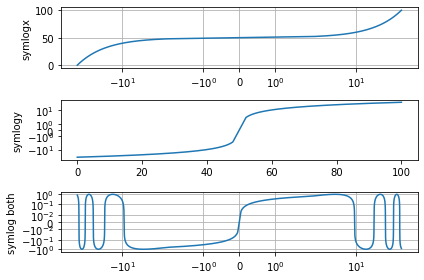

In [66]:
dt = 0.01
x = np.arange(-50.0, 50.0, dt)
y = np.arange(0, 100.0, dt)

fig, (ax0, ax1, ax2) = plt.subplots(nrows=3)

ax0.plot(x, y)
ax0.set_xscale('symlog')
ax0.set_ylabel('symlogx')
ax0.grid()
ax0.xaxis.grid(which='minor')  # minor grid on too

ax1.plot(y, x)
ax1.set_yscale('symlog')
ax1.set_ylabel('symlogy')

ax2.plot(x, np.sin(x / 3.0))
ax2.set_xscale('symlog')
ax2.set_yscale('symlog', linthresh=0.015)
ax2.grid()
ax2.set_ylabel('symlog both')

fig.tight_layout()
plt.show()

## process figures

In [ ]:
traces= glob.glob('data/meta_unfilt/*bedgraph')
ori=pd.read_csv('data/doric10/OriC_db.bed',sep='\t')

for jac in traces:
    zzz=pd.read_csv(jac,sep='\t',names=['tmp','start','end','relAb'])
    tmp=ori[ori['Refseq'].str.contains('NC_'+jac.split('/')[2].split('_')[1])]
    
    plt.figure(figsize=(20, 5))
    try:
        print('running: '+str(tmp['Organism'].item())+" in "+str(os.path.basename(jac).split('_')[2].split('.')[0]))
        ss=np.int(np.round(tmp['start'].item(),-1))
        tt=np.int(np.round(tmp['end'].item(),-1))
        plt.bar(data=zzz[(zzz['start']>ss-250000)&(zzz['end']<tt+250000)],x='start',height='relAb',label='align',color='blue')#][zzz['start']=='1665929']
        plt.bar(data=tmp,x='start',height='OriC AT content',label='OriC start',color='orange')
        plt.bar(data=tmp,x='end',height='OriC AT content',label='OriC end',color='orange')

        plt.axes([.2, .6, .6, .2])
        plt.bar(data=zzz[(zzz['start']>ss-100) &(zzz['end']<tt+100)],x='start',height='relAb',label='align',color='blue')#][zzz['start']=='1665929']
        plt.bar(data=tmp,x='start',height='OriC AT content',label='OriC start',color='orange')
        plt.bar(data=tmp,x='end',height='OriC AT content',label='OriC end',color='orange')

        plt.xlabel("OriC ranges from "+str(tmp['start'].item())+" to "+str(tmp['end'].item())+" for "
            +str(tmp['Organism'].item())+" in "+str(os.path.basename(jac).split('_')[2].split('.')[0])+"max= "+
                   np.max(zzz['relAb'])+" between "+str(np.int(zzz[zzz['relAb']==np.max(zzz['relAb'])][['start']].values))+" and "+str(np.int(zzz[zzz['relAb']==np.max(zzz['relAb'])][['end']].values))+"; median= "+np.median(zzz['relAb']),fontsize=14)
        plt.savefig('img/oric/'+str(os.path.basename(jac).split('.')[0])+'.png',dpi=300,bbox_inches = "tight")

    except TypeError:
        pass
    except ValueError:
        pass

In [ ]:
ori[ori['Organism']=='Staphylococcus_aureus']

In [ ]:
tmp=ori[ori['Refseq'].str.contains('NC_'+jac.split('/')[2].split('_')[1])]

# analyze and score OriC v rest

In [ ]:

def run_vRand(dataset,table,n):
    aa=dataset.loc[dataset.index.isin(np.unique(table['subj']))]
    aa['ecoli']=1
    aa=aa.select_dtypes(include=np.number)
    aa=aa.dropna(how='any',axis=1)

    bb=dataset.loc[~dataset.index.isin(np.unique(table['subj']))]
    bb['ecoli']=0
    bb=bb.select_dtypes(include=np.number)
    bb=bb.dropna(how='any',axis=1)

    for i in aa.columns:
        try:
            cc=stats.kruskal(aa[i].dropna(),bb[i].dropna())
            dd=stats.mannwhitneyu(aa[i].dropna(),bb[i].dropna())
            ee=stats.ttest_ind(aa[i].dropna(),bb[i].dropna())
            # ff=stats.wilcoxon(aa[i].dropna(),bb[i].dropna())
            if ((cc.pvalue<0.005) & (dd.pvalue<0.005)&(ee.pvalue<0.005)):
                print (i,cc.pvalue,dd.pvalue,ee.pvalue)

        except:
            pass

    for i in np.arange(n):
        jeff=np.random.permutation(dataset.index)[0:len(np.unique(table['subj']))]
        aa=dataset.loc[dataset.index.isin(jeff)]
        aa=aa.select_dtypes(include=np.number)
        aa=aa.dropna(how='any',axis=1)

        bb=dataset.loc[~dataset.index.isin(jeff)]
        bb=bb.select_dtypes(include=np.number)
        bb=bb.dropna(how='any',axis=1)
        for i in aa.columns:
            try:
                cc=stats.kruskal(aa[i].dropna(),bb[i].dropna())
                dd=stats.mannwhitneyu(aa[i].dropna(),bb[i].dropna())
                ee=stats.ttest_ind(aa[i].dropna(),bb[i].dropna())
                # ff=stats.wilcoxon(aa[i].dropna(),bb[i].dropna())
                if ((cc.pvalue<0.005) & (dd.pvalue<0.005)&(ee.pvalue<0.005)):
                    print (i,cc.pvalue,dd.pvalue,ee.pvalue)

            except:
                pass

In [ ]:
# ori=pd.read_csv('data/doric10/OriC_db.bed',sep='\t')

cc=pd.DataFrame(ori.Refseq.str.split('.').str[0].tolist())

(cc[cc[0].isin(traces)])

In [ ]:
table=pd.DataFrame()
traces= glob.glob('data/meta*/*bedgraph')
traces=np.sort(traces)
indices = [i for i, s in enumerate(traces) if 'R0295-KKL' in s]
ori=pd.read_csv('data/doric10/OriC_db.bed',sep='\t')
pattable=pd.DataFrame()

# samtools flagstat NC_013008_R0397-LWS_bowtie.sorted.bam
for jac in indices:
    trace=traces[jac]
    zzz=pd.read_csv(trace,sep='\t',names=['tmp','start','end','relAb'])
    tmp=ori[ori['Refseq'].str.contains('NC_'+trace.split('/')[2].split('_')[1])]
    # print(str(tmp['Organism']))
    pat=trace.split('_')[2].split('.')[0]
    try:
        zzz['len']=zzz['end']-zzz['start']

        ss=np.int(np.round(tmp['start'].item(),-1))
        tt=np.int(np.round(tmp['end'].item(),-1))

        ccc=np.int(np.round(tmp['start'].item(),0))-50
        ddd=np.int(np.round(tmp['end'].item(),0))+50
        www0=zzz[((zzz['start']<ccc)|(zzz['end']>ddd))]
        # www1=zzz[]
        yyy=zzz[(zzz['start']>ccc)&(zzz['end']<ddd)]
        # print([len(zzz),len(www0),len(yyy)])
        # if (np.max(www0.relAb)<np.max(yyy.relAb)):
        # print(str(tmp['Organism'].item()))
        # print([np.max(www0.relAb),np.max(yyy.relAb)])
        plt.figure(figsize=(20,8))
        tmpA=plt.hist(www0.relAb,bins=100,log=True)
        # tmpA=plt.hist(www1.relAb,bins=100,log=True)
        tmpA=plt.hist(yyy.relAb,bins=100,log=True,alpha=0.5)
        # tmpD=(np .max(yyy.relAb))
        tmp['OriC max_relAb']=(np.max(yyy.relAb))
        tmp['background max_relAb']=(np.max(www0.relAb))
        (np.max(www0.relAb))
        plt.xlabel(str(tmp['Organism'].item())+' OriC max_relAb:'+str(tmp['OriC max_relAb'].item())+', background max_relAb:'+str(tmp['background max_relAb'].item()))
        # pattable=pd.concat([pattable,pat],axis=0)
        plt.savefig('img/oric_hist/'+str(os.path.basename(trace).split('.')[0])+'.png',dpi=300,bbox_inches = "tight")

        table=pd.concat([table,tmp],axis=0)
    except ValueError:
        pass
# table['subj']=table['pat'].str.split('-').str[0].tolist()
# table.to_csv('data/oriC_calc_lenWeighted_trim_mean.txt',sep='\t',append=True)

In [ ]:
table=pd.DataFrame()
traces= glob.glob('data/meta_unfilt/*bedgraph')
traces=np.sort(traces)
ori=pd.read_csv('data/doric10/OriC_db.bed',sep='\t')
pattable=pd.DataFrame()
# samtools flagstat NC_013008_R0397-LWS_bowtie.sorted.bam
for jac in traces:
    zzz=pd.read_csv(jac,sep='\t',names=['tmp','start','end','relAb'])
    tmp=ori[ori['Refseq'].str.contains('NC_'+jac.split('/')[2].split('_')[1])]
    # print(str(tmp['Organism']))
    pat=jac.split('_')[2].split('.')[0]
    try:
        zzz['len']=zzz['end']-zzz['start']
        # zzz=zzz[zzz['len']==50]
        # zzz['relAb'].replace(0,1)
        # zzz['score']=zzz['relAb']/zzz['len']
        # zzz['score']=
        ss=np.int(np.round(tmp['start'].item(),-1))
        tt=np.int(np.round(tmp['end'].item(),-1))
        tmpd=zzz[(zzz['start']>ss) &(zzz['end']<tt)]
        tmpdd=zzz[(zzz['start']>ss-250) &(zzz['end']<tt+250)]
        tmpddd=zzz[(zzz['start']>ss-500) &(zzz['end']<tt+500)]

        tmp['mean']=np.sum(zzz['relAb']*zzz['len'])/np.sum(zzz['len'])#np.mean(zzz['score'])
        tmp['ori_mean']=np.sum(tmpd['relAb']*tmpd['len'])/np.sum(tmpd['len'])#np.mean(tmpd['score'])
        tmp['ori_mean_250']=np.sum(tmpdd['relAb']*tmpdd['len'])/np.sum(tmpdd['len'])#np.mean(tmpdd['score'])
        tmp['ori_mean_500']=np.sum(tmpddd['relAb']*tmpddd['len'])/np.sum(tmpddd['len'])#np.mean(tmpddd['score'])
        
        tmp['trim_mean01']=stats.trim_mean(zzz['relAb'],0.01)
        tmp['ori_trim_mean01']=stats.trim_mean(tmpd['relAb'],0.01)
        tmp['ori_trim_mean01_250']=stats.trim_mean(tmpdd['relAb'],0.01)
        tmp['ori_trim_mean01_500']=stats.trim_mean(tmpddd['relAb'],0.01)
        
        tmp['trim_mean1']=stats.trim_mean(zzz['relAb'],0.1)
        tmp['ori_trim_mean1']=stats.trim_mean(tmpd['relAb'],0.1)
        tmp['ori_trim_mean1_250']=stats.trim_mean(tmpdd['relAb'],0.1)
        tmp['ori_trim_mean1_500']=stats.trim_mean(tmpddd['relAb'],0.1)
        
        tmp['trim_mean25']=stats.trim_mean(zzz['relAb'],0.25)
        tmp['ori_trim_mean25']=stats.trim_mean(tmpd['relAb'],0.25)
        tmp['ori_trim_mean25_250']=stats.trim_mean(tmpdd['relAb'],0.25)
        tmp['ori_trim_mean25_500']=stats.trim_mean(tmpddd['relAb'],0.25)
        
        tmp['pat']=pat
        
        
        ccc=np.int(np.round(tmp['start'].item(),0))-50
        ddd=np.int(np.round(tmp['end'].item(),0))+50
        www0=zzz[((zzz['start']<ccc)|(zzz['end']>ddd))]
        # www1=zzz[]
        yyy=zzz[(zzz['start']>ccc)&(zzz['end']<ddd)]
        # print([len(zzz),len(www0),len(yyy)])
        if (np.max(www0.relAb)<np.max(yyy.relAb)):
            # print(str(tmp['Organism'].item()))
            # print([np.max(www0.relAb),np.max(yyy.relAb)])
            plt.figure(figsize=(20,8))
            tmpA=plt.hist(www0.relAb,bins=100,log=True)
            # tmpA=plt.hist(www1.relAb,bins=100,log=True)
            tmpA=plt.hist(yyy.relAb,bins=100,log=True,alpha=0.5)
            # tmpD=(np .max(yyy.relAb))
            tmp['OriC max_relAb']=(np.max(yyy.relAb))
            tmp['background max_relAb']=(np.max(www0.relAb))
            (np.max(www0.relAb))
            plt.xlabel(str(tmp['Organism'].item())+' OriC max_relAb:'+str(tmp['OriC max_relAb'].item())+', background max_relAb:'+str(tmp['background max_relAb'].item()))
            # pattable=pd.concat([pattable,pat],axis=0)
            plt.savefig('img/oric_hist_unfilt/oric_hist_'+str(os.path.basename(jac).split('.')[0])+'.png',dpi=300,bbox_inches = "tight")

            table=pd.concat([table,tmp],axis=0)
    except ValueError:
        pass
table['subj']=table['pat'].str.split('-').str[0].tolist()
table.to_csv('data/oriC_calc_lenWeighted_trim_mean.txt',sep='\t')

In [ ]:
table.to_csv('data/unfilt_oriC_calc_lenWeighted_trim_mean.txt',sep='\t')

In [ ]:
table=pd.read_csv('data/oriC_calc_lenWeighted_trim_mean.txt',sep='\t')

In [ ]:
primary=pd.read_excel('data/Data Raw - Gut Microbiome Cohort Project Database - 300 Cohort v3.0_280921.xlsx',index_col=0,sheet_name='Primary Data')
diet=pd.read_excel('data/Data Raw - Gut Microbiome Cohort Project Database - 300 Cohort v3.0_280921.xlsx',index_col=0,sheet_name='Diet Data')
blood_stool=pd.read_excel('data/Data Raw - Gut Microbiome Cohort Project Database - 300 Cohort v3.0_280921.xlsx',index_col=0,sheet_name='blood and stool biomarkers')
secondary=pd.read_excel('data/Data Raw - Gut Microbiome Cohort Project Database - 300 Cohort v3.0_280921.xlsx',index_col=0,sheet_name='Secondary Data')
MRI=pd.read_excel('data/Data Raw - Gut Microbiome Cohort Project Database - 300 Cohort v3.0_280921.xlsx',index_col=0,sheet_name='MRI scores')

In [ ]:
run_vRand(diet,table,100)

In [ ]:
aa=aa.append(bb)
sns.violinplot(x=aa['ecoli'],y=aa['Niacin_mg'])

In [ ]:
aa['Niacin_mg']

In [ ]:
run_vRand(primary,table,100)

In [ ]:
run_vRand(secondary,table,100)

In [ ]:
run_vRand(blood_stool,table,100)

In [ ]:
run_vRand(MRI,table,100)

In [ ]:
aa=secondary.loc[secondary.index.isin(np.unique(table['subj']))]
aa=aa.select_dtypes(include=np.number)
aa=aa.dropna(how='any',axis=1)

bb=secondary.loc[~secondary.index.isin(np.unique(table['subj']))]
bb=bb.select_dtypes(include=np.number)
bb=bb.dropna(how='any',axis=1)

In [ ]:
tmp=plt.hist(zzz['score'],bins=100,log=True)
tmp=plt.hist(tmpd['score'],bins=100,log=True)
tmp=plt.hist(tmpdd['score'],bins=100,log=True)
tmp=plt.hist(tmpddd['score'],bins=100,log=True)

### compare output

In [ ]:
table.groupby('pat').mean()

In [ ]:
a=plt.hist(table['mean'],bins=100,log=True,alpha=.65)
a=plt.hist(table['ori_mean'],bins=100,log=True,alpha=.5)
a=plt.hist(table['ori_mean_250'],bins=100,log=True,alpha=.35)
a=plt.hist(table['ori_mean_500'],bins=100,log=True,alpha=.25)

In [ ]:
np.sum(table['mean']>table['ori_mean'])/len(table)

In [ ]:
np.sum(table['median']>table['ori_median'])/len(table)

In [ ]:
table.groupby('Organism').median()

In [ ]:
table.groupby('Organism').mean()

In [ ]:
unibact=pd.read_csv('data/328_krakenuniq_raw.csv',index_col=0)
unibact['spec']=(unibact.index).str.split(';').str[0:6].tolist()
jeff=pd.DataFrame(unibact['spec'].tolist(),columns=['tmp','tmp','tmp','tmp','tmp','species'])
jeff=jeff.fillna(method='ffill',axis=1)

In [ ]:
(unibact.index).str.split(';').str[0:6].tolist()[0][5] ## transfered a bunch of these from hku to personal cpos

In [ ]:
jeff[jeff['species'].str.contains('prevot')]#[1:50]
# jeff.ind# tmp=ori[ori['Refseq'].str.contains('NC_'+jac.split('/')[2].split('_')[1])]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
# N = np.sum(zzz.len)#len(table['mean'])
bottom = 8
max_height = 4

theta = zzz['start']#np.linspace(0.0, 2 * np.pi, N, endpoint=False)
radii = zzz['relAb']#max_height*np.random.rand(N)
width = zzz['len'] #(2*np.pi) / N

ax = plt.subplot(111, polar=True)
bars = ax.bar(x=theta, height=radii, width=width, bottom=bottom)

# Use custom colors and opacity
for r, bar in zip(radii, bars):
    bar.set_facecolor(plt.cm.jet(r / 10.))
    bar.set_alpha(0.8)

plt.show()

In [ ]:
ccc=np.int(np.round(tmp['start'].item(),0))-500
ddd=np.int(np.round(tmp['end'].item(),0))+500
www0=zzz[(zzz['start']<ccc)]
www1=zzz[(zzz['end']>ddd)]
yyy=zzz[(zzz['start']>ccc)&(zzz['end']<ddd)]
[len(zzz),len(www0),len(yyy),len(www1)]
[np.max(www0.relAb),np.max(www1.relAb),np.max(yyy.relAb)]

In [ ]:
np.int(np.round(np.max(yyy.relAb),-3)/100)

In [ ]:
plt.figure(figsize=(20,8))
tmpA=plt.hist(www0.relAb,bins=100,log=True)
tmpA=plt.hist(www1.relAb,bins=100,log=True)
tmpA=plt.hist(yyy.relAb,bins=100,log=True)
# plt.label

In [ ]:
# initialize the figure
plt.figure(figsize=(20,10))
ax = plt.subplot(111, polar=True)
plt.axis('off')

# Draw bars
bars = ax.bar(
    x=angles, 
    height=heights, 
    width=width, 
    bottom=lowerLimit,
    linewidth=2, 
    edgecolor="white",
    color="#61a4b2",
)

# little space between the bar and the label
labelPadding = 4

# Add labels
for bar, angle, height, label in zip(bars,angles, heights, df["Name"]):

    # Labels are rotated. Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle)

    # Flip some labels upside down
    alignment = ""
    if angle >= np.pi/2 and angle < 3*np.pi/2:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"

    # Finally add the labels
    ax.text(
        x=angle, 
        y=lowerLimit + bar.get_height() + labelPadding, 
        s=label, 
        ha=alignment, 
        va='center', 
        rotation=rotation, 
        rotation_mode="anchor") 

In [ ]:
# ori['len']=ori['end']-ori['start']
np.sort(ori['len'])ATACxGEX=pd.read_csv('/content/drive/My

In [ ]:
ATACxGEX=pd.read_csv('data/neurIPS2021/ATACxGEX_O.bed',sep='\t',names=['chr','start','end','id','gene','chr2','start2','end2','hits'])
GEXxATAC=pd.read_csv('data/neurIPS2021/GEXxATAC_O.bed',sep='\t',names=['chr','start','end','id','gene','chr2','start2','end2','hits'])

In [ ]:
plt.figure(figsize=(20, 5))
dd=GEXxATAC[GEXxATAC['chr']=='chr1']
plt.bar(data=dd,x=np.log(dd['start']),height='hits')

In [ ]:
import duolingo
lingo  = duolingo.Duolingo('dcolinmorgan', 'M6742632')

In [ ]:
# lingo  = duolingo.Duolingo('kartik', '...')
ww=(lingo.get_known_words('sv'))
vv=lingo.get_translations(ww, source='sv', target='en')

In [ ]:
# with open('dcm_duolingo.csv', 'w') as f:  # You will need 'wb' mode in Python 2.x
#     w = csv.DictWriter(f, vv.keys())
#     w.writeheader()
#     w.writerow(vv)

import json
# with open('dcm_duolingo.txt', 'w') as file:
#      file.write(json.dumps(vv))
        
with open('dcm_duolingo.txt', 'w', encoding='utf-8') as f:
    json.dump(vv, f, ensure_ascii=False, indent=4)

In [ ]:
# pp=(lingo.get_vocabulary(language_abbr='sv'))
pd.DataFrame((pp))

In [ ]:

pp.keys()

In [ ]:
pp.vocab_overview

# replot TSS

In [ ]:
pd.read_csv('/groups/cgsd/gordonq/TSS_depth/nanopore_data/')

# troubleshoot

In [378]:
bact_stat=pd.read_csv('flagstatA.txt',sep='\t',names=['q0','q1','type'])
bact_stat['sample']=bact_stat[bact_stat['q0'].str.contains(".bam")]['q0'].repeat(21).values
# bact_stat.loc[1:1000]
bact_stat['bact']=bact_stat['sample'].str.split('_').str[1].tolist()
bact_stat['pat']=bact_stat['sample'].str.split('_').str[2].tolist()
del bact_stat['sample'], bact_stat['q1']
bact_stat.dropna(how='any',inplace=True)
bact_stat=bact_stat[~bact_stat.type.str.contains("%")]

In [337]:
bact_stat['q0']=bact_stat.q0.astype('int')
bact_stat['q1']=np.log10(bact_stat['q0'])

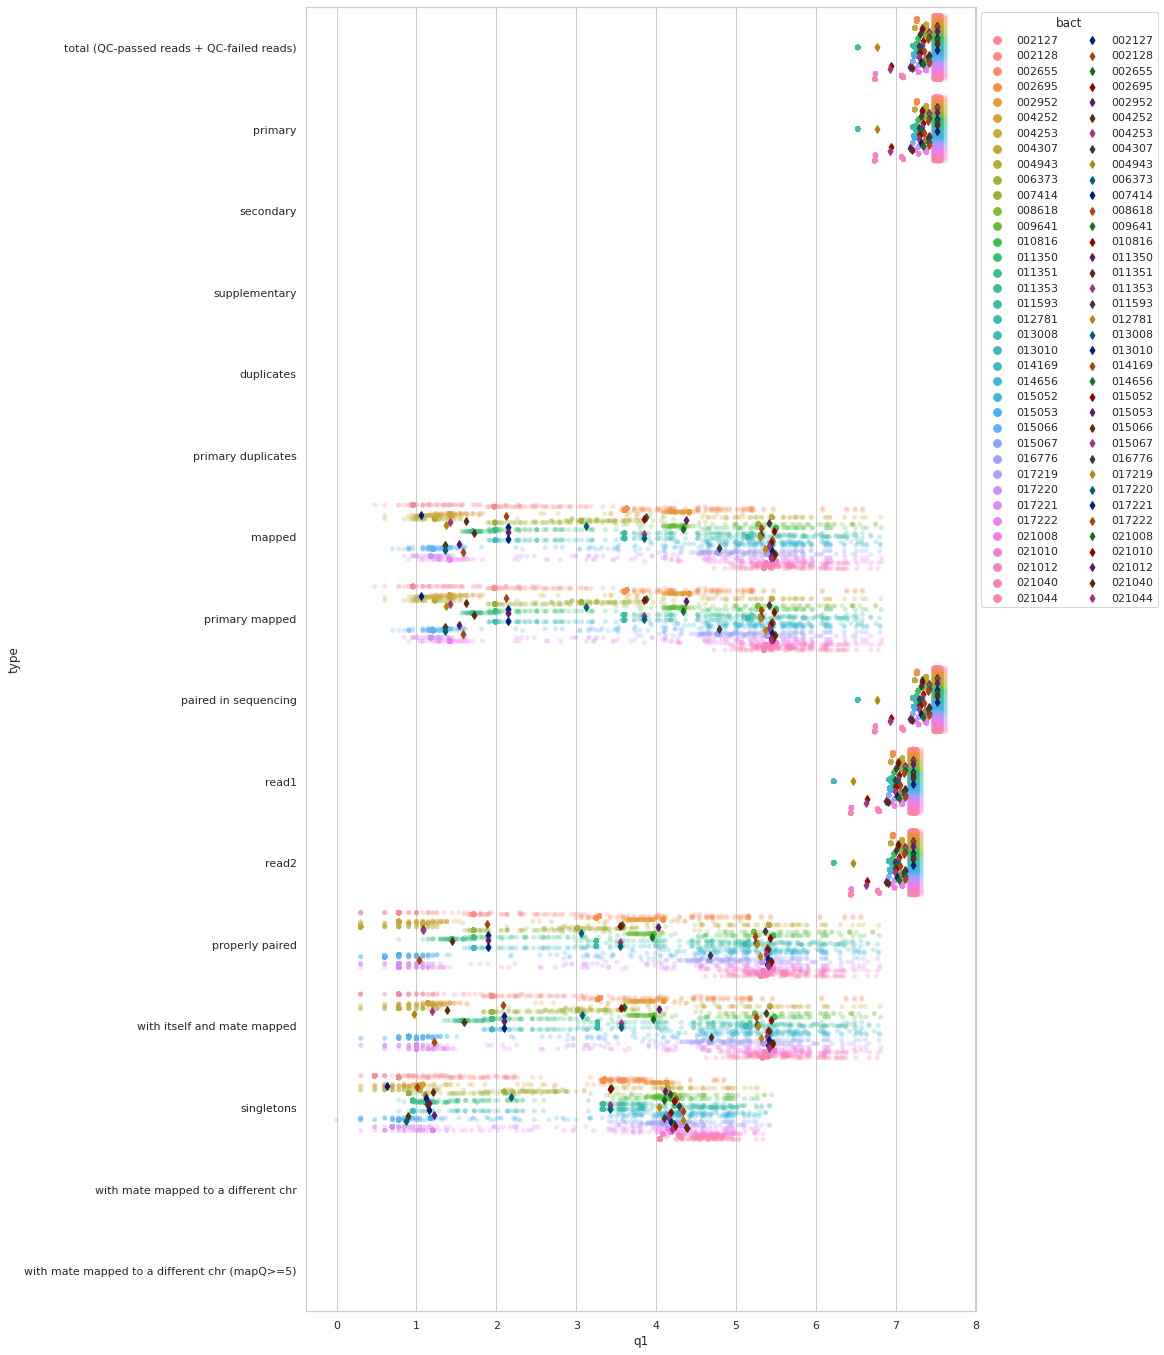

In [356]:
sns.set_theme(style="whitegrid")
# iris = sns.load_dataset("iris")
plt.figure(figsize=(12, 24))
# "Melt" the dataset to "long-form" or "tidy" representation
# iris = pd.melt(bact_stat, ["bact",'patient'], var_name="type")
# del bact_stat['sample'], bact_stat['q1']
# bact_stat.dropna(how='any',inplace=True)
# bact_stat=bact_stat[~bact_stat.type.str.contains("%")]
# Initialize the figure
# f, ax = plt.subplots()
# sns.despine(bottom=True, left=True)

# Show each observation with a scatterplot
ax=sns.stripplot(x="q1", y="type", hue="bact",
              data=bact_stat, dodge=True, alpha=.25, zorder=1)

# Show the conditional means, aligning each pointplot in the
# center of the strips by adjusting the width allotted to each
# category (.8 by default) by the number of hue levels
ax=sns.pointplot(x="q1", y="type", hue="bact",
              data=bact_stat, dodge=.8 - .8 / 3,
              join=False, palette="dark",
              markers="d", scale=.75, ci=None)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1),ncol=2)
plt.savefig("flagstat.png",dpi=300,bbox_inches = "tight")

# Improve the legend
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels, title="bact",
#           handletextpad=0, columnspacing=1,
#           loc='lower center', ncol=5, frameon=False)#,bbox_to_anchor=(1.05, 1),borderaxespad=0.)


In [384]:
jeff=pd.pivot_table(bact_stat,columns='type',index=['bact','pat'],values='q0')

In [388]:
jeff=jeff.reset_index()

In [401]:
jeff =jeff.loc[:, (jeff != 0).any(axis=0)]
# del jeff['secondary']  
del jeff['primary mapped'], jeff['with itself and mate mapped']

In [402]:
jeff

type,bact,pat,mapped,paired in sequencing,primary,properly paired,read1,read2,singletons,total (QC-passed reads + QC-failed reads)
0,002127,R0003-CPK-DNA,9.0,32849196.0,32849196.0,6.0,16424598.0,16424598.0,3.0,1.642460e+15
1,002127,R0005-LMF-DNA,9.0,32849196.0,32849196.0,6.0,16424598.0,16424598.0,3.0,1.642460e+15
2,002127,R0015-MSW-DNA,9.0,32849196.0,32849196.0,6.0,16424598.0,16424598.0,3.0,3.284920e+07
3,002127,R0017-LLP-DNA,9.0,32849196.0,32849196.0,6.0,16424598.0,16424598.0,3.0,1.642460e+15
4,002127,R0018-LKC-DNA,9.0,32849196.0,32849196.0,6.0,16424598.0,16424598.0,3.0,3.284920e+07
...,...,...,...,...,...,...,...,...,...,...
7617,021044,header.e47023,224174.0,5490180.0,5490180.0,207004.0,2745090.0,2745090.0,11152.0,5.490180e+06
7618,021044,header.e817472,224174.0,5490180.0,5490180.0,207004.0,2745090.0,2745090.0,11152.0,5.490180e+06
7619,021044,header.o47023,224174.0,5490180.0,5490180.0,207004.0,2745090.0,2745090.0,11152.0,5.490180e+06
7620,021044,header.o817472,224174.0,5490180.0,5490180.0,207004.0,2745090.0,2745090.0,11152.0,5.490180e+06


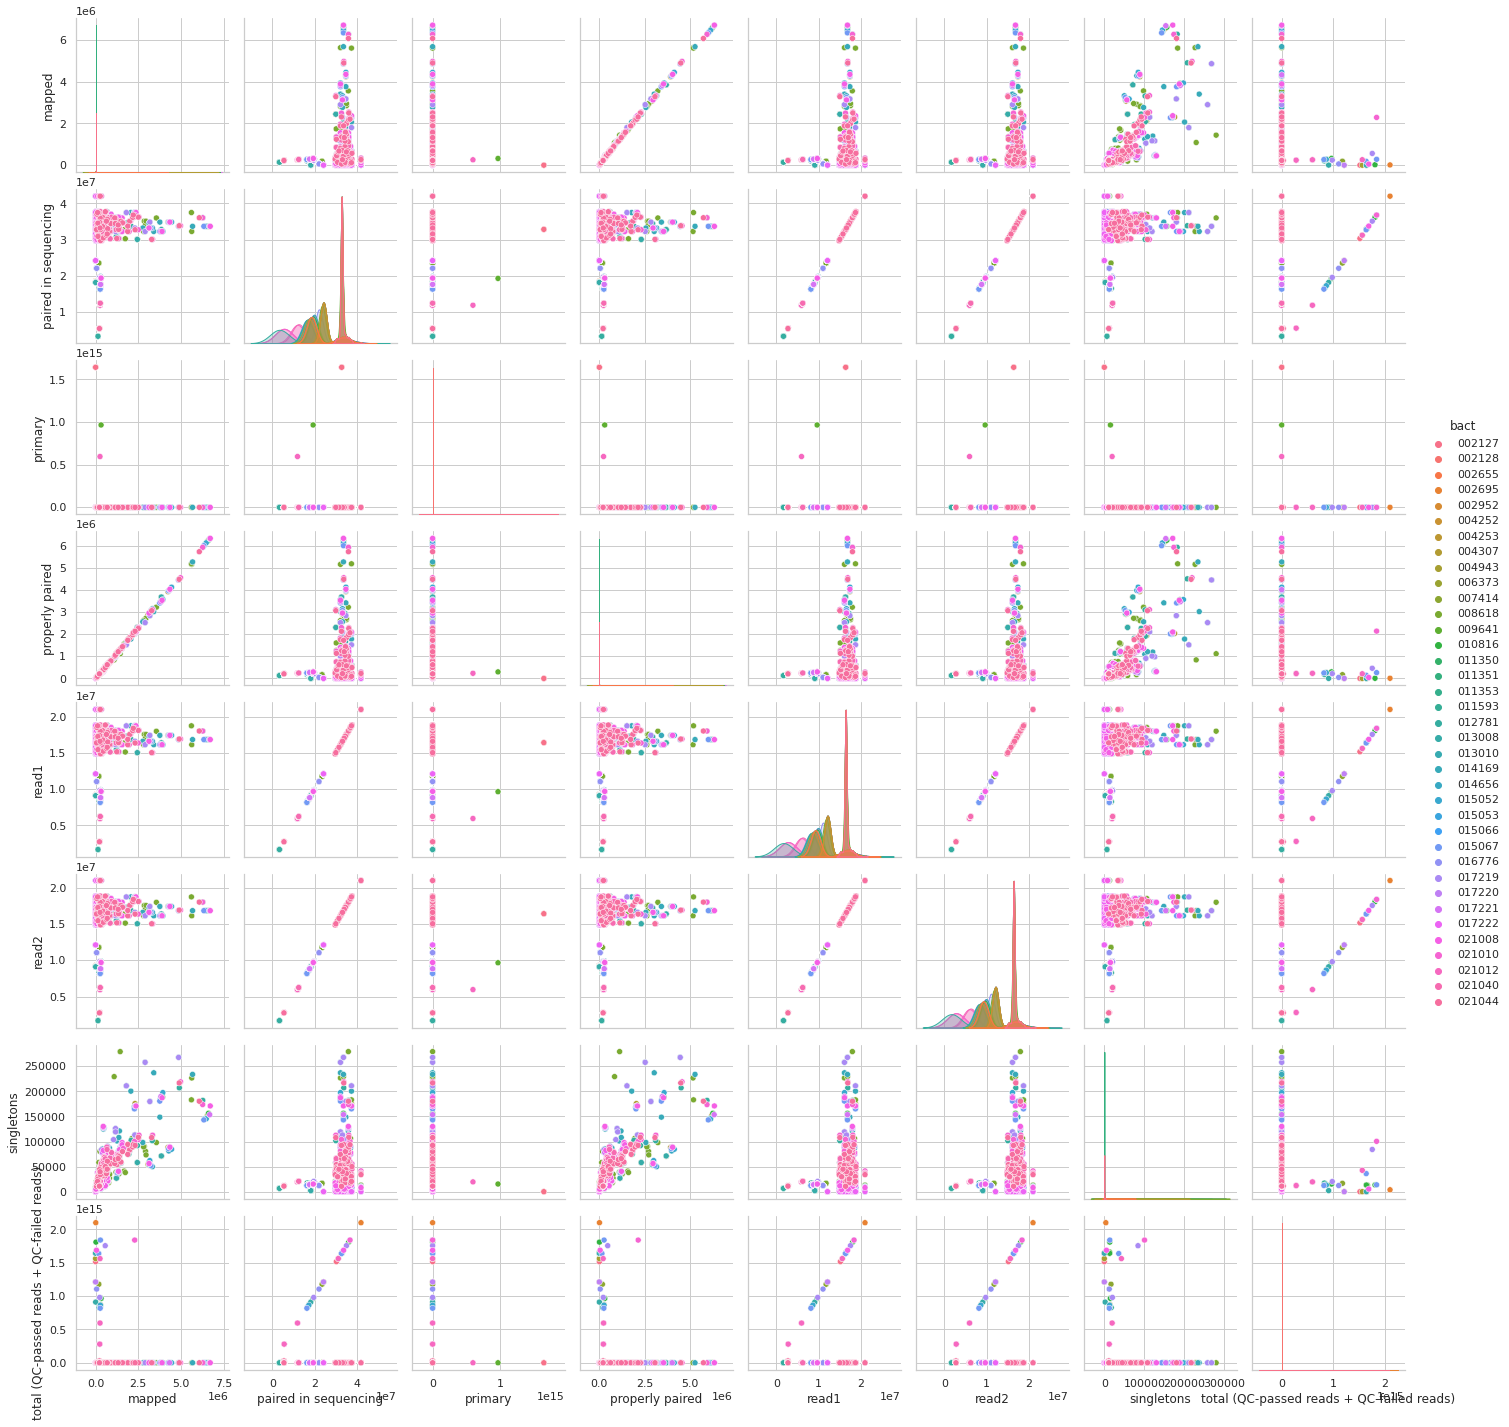

In [403]:
sns.pairplot(jeff, hue="bact")
plt.savefig("flagstat_corr.png",dpi=300,bbox_inches = "tight")


In [404]:
jeff0=pd.melt(jeff,id_vars=['bact','pat'])

In [410]:
jeff0['log10_value']=np.log10(jeff0.value)

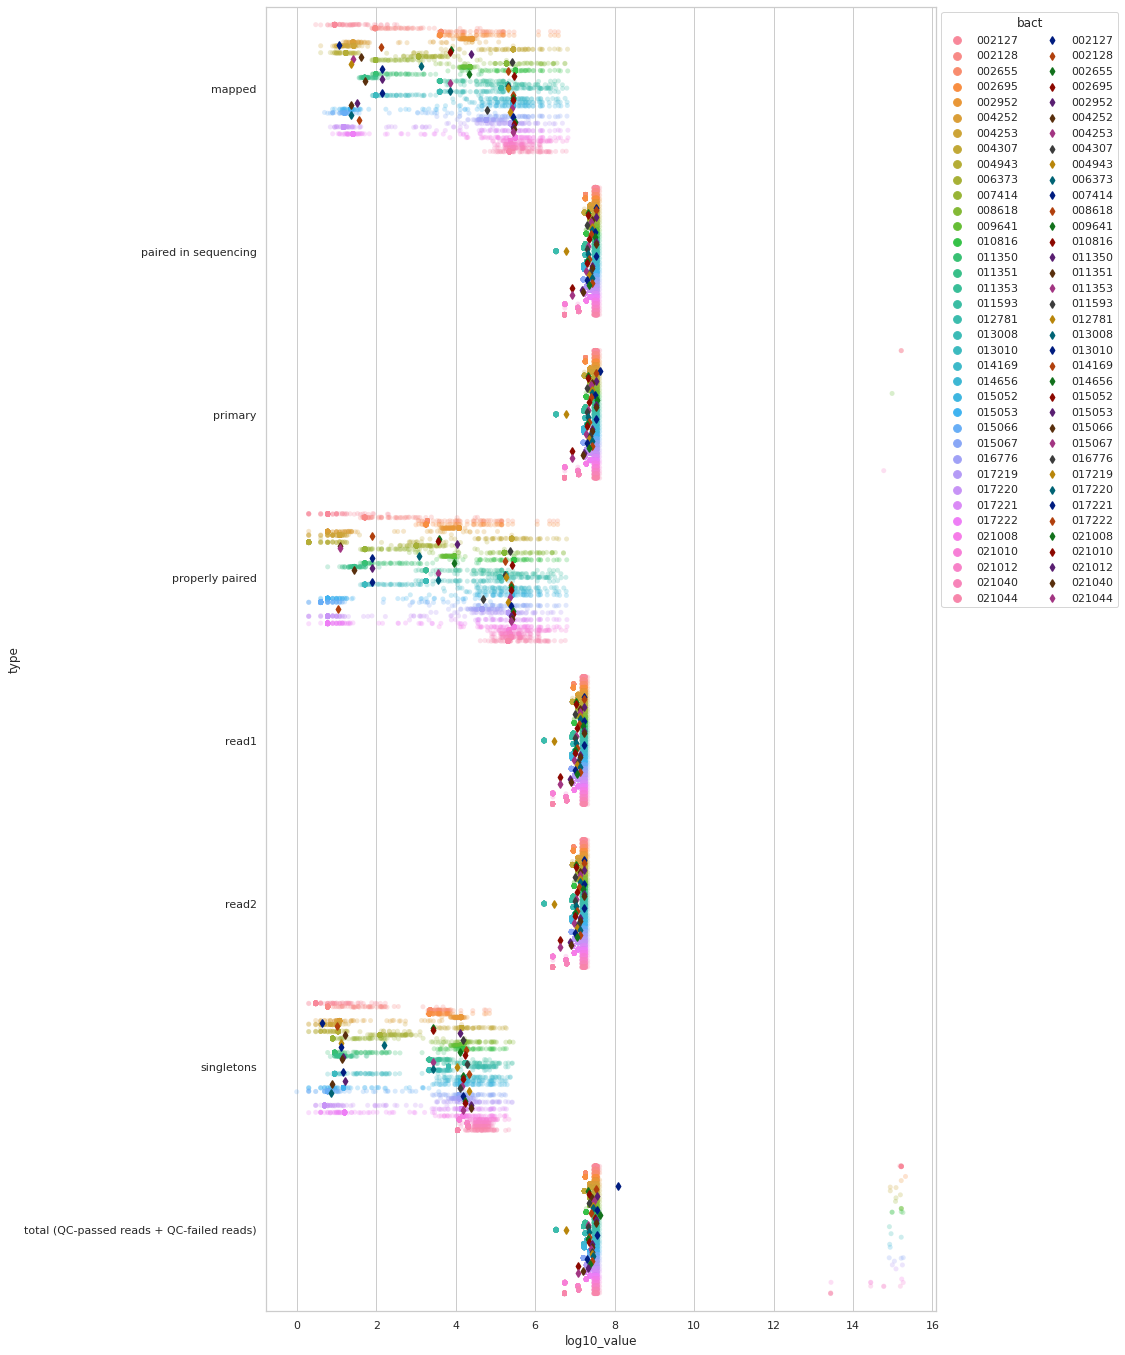

In [411]:
sns.set_theme(style="whitegrid")
# iris = sns.load_dataset("iris")
plt.figure(figsize=(12, 24))
# "Melt" the dataset to "long-form" or "tidy" representation
# iris = pd.melt(bact_stat, ["bact",'patient'], var_name="type")
# del bact_stat['sample'], bact_stat['q1']
# bact_stat.dropna(how='any',inplace=True)
# bact_stat=bact_stat[~bact_stat.type.str.contains("%")]
# Initialize the figure
# f, ax = plt.subplots()
# sns.despine(bottom=True, left=True)

# Show each observation with a scatterplot
ax=sns.stripplot(x="log10_value", y="type", hue="bact",
              data=jeff0, dodge=True, alpha=.25, zorder=1)

# Show the conditional means, aligning each pointplot in the
# center of the strips by adjusting the width allotted to each
# category (.8 by default) by the number of hue levels
ax=sns.pointplot(x="log10_value", y="type", hue="bact",
              data=jeff0, dodge=.8 - .8 / 3,
              join=False, palette="dark",
              markers="d", scale=.75, ci=None)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1),ncol=2)
plt.savefig("flagstat_red.png",dpi=300,bbox_inches = "tight")

# Improve the legend
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels, title="bact",
#           handletextpad=0, columnspacing=1,
#           loc='lower center', ncol=5, frameon=False)#,bbox_to_anchor=(1.05, 1),borderaxespad=0.)
